In [ ]:
# Test 7 - Fully Updated with Nested CV Evaluation (Unbiased) and Final Ensemble Pipeline
# !pip install imbalanced-learn openpyxl  # run once in Colab

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import copy  # for correct early stopping

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.special import expit
import random

# ---------------------------------------------------
# 0. CONFIG + Reproducibility & Device
# ---------------------------------------------------
SEED = 42
RUN_NESTED_CV = True   # Set to False if training time is too long

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# 1. Load Data
# ---------------------------------------------------
def load_and_preprocess_data():
    labeled_path = "https://drive.google.com/uc?id=15WUl8ilQyE2MRXjnO-V2x7rJXNMxI7qI"
    unlabeled_path = "https://drive.google.com/uc?id=1J57A0_EdtHW4yZU1Kus6ymekxM4DzZrp"

    df_labeled = (
        pd.read_excel(labeled_path, engine="openpyxl")
          .rename(columns={"Unnamed: 0": "index"})
    )
    df_unlabeled = (
        pd.read_excel(unlabeled_path, engine="openpyxl")
          .rename(columns={"Unnamed: 0": "index"})
    )

    print(f"Labeled data shape: {df_labeled.shape}")
    print(f"Unlabeled data shape: {df_unlabeled.shape}")

    index_col, target_col = "index", "label"
    X = df_labeled.drop(columns=[index_col, target_col])
    y = df_labeled[target_col].values
    X_unlabeled = df_unlabeled.drop(columns=[index_col])

    labeled_indices = df_labeled[index_col].values
    unlabeled_indices = df_unlabeled[index_col].values

    return X, y, X_unlabeled, labeled_indices, unlabeled_indices

X, y, X_unlabeled, labeled_indices, unlabeled_indices = load_and_preprocess_data()
print(f"\nLabeled X shape: {X.shape}, y shape: {y.shape}")
print(
    f"Class distribution: {np.bincount(y)} "
    f"(Imbalance ratio: {np.bincount(y)[0]/np.bincount(y)[1]:.2f}:1)"
)

# ---------------------------------------------------
# 2. Preprocessing Pipeline
# ---------------------------------------------------
cat_cols = ["x2", "x3", "x4"]
num_cols = ["x15", "x16", "x17", "x18", "x19", "x20", "x21"]
bin_cols = [c for c in X.columns if c not in cat_cols + num_cols]

print(f"Categorical columns: {cat_cols}")
print(f"Numerical columns: {num_cols}")
print(f"Binary columns: {len(bin_cols)} columns")

cat_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_transformer = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('passthrough', 'passthrough')
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols),
        ('num', num_transformer, num_cols),
        ('bin', bin_transformer, bin_cols)
    ],
    remainder='drop'
)

# ---------------------------------------------------
# 3. TWO DIFFERENT MLP ARCHITECTURES
# ---------------------------------------------------
class ResidualBlock(nn.Module):
    """Residual block that safely handles dimension changes via a learnable skip."""
    def __init__(self, in_dim, out_dim, dropout=0.3):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(out_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.bn2 = nn.BatchNorm1d(out_dim)

        # If dimensions differ, learn a projection for the skip connection
        self.skip = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()

    def forward(self, x):
        residual = self.skip(x)

        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.linear2(out)
        out = self.bn2(out)

        out = out + residual
        out = self.relu(out)
        return out


class EnhancedMLP(nn.Module):
    """Enhanced Model Architecture: [256 → 128 → 64] with residual blocks."""
    def __init__(self, input_dim):
        super().__init__()

        # First layer: input_dim → 256
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Residual blocks with dimension changes handled via projection
        self.res1 = ResidualBlock(256, 128, dropout=0.3)
        self.res2 = ResidualBlock(128, 64, dropout=0.3)

        # Final output layer
        self.output = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.res1(x)
        x = self.res2(x)
        return self.output(x).squeeze(1)


class OptimizedMLP(nn.Module):
    """Optimized Model Architecture: [512, 256] with SELU."""
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.SELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.SELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)


# ---------------------------------------------------
# 4. TRAINING FUNCTION
# ---------------------------------------------------
def train_mlp(model_class, X_train, y_train, lr=5e-4, weight_decay=1e-4,
              l1_lambda=0.001, epochs=80, patience=10, verbose=True):
    """
    Generic MLP training function.
    Early stopping correctly restores the best epoch
    using copy.deepcopy on state_dict().
    """

    input_dim = X_train.shape[1]
    X_tr_t = torch.tensor(X_train, dtype=torch.float32)
    y_tr_t = torch.tensor(y_train, dtype=torch.float32)

    train_ds = TensorDataset(X_tr_t, y_tr_t)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

    model = model_class(input_dim).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Since we may pass SMOTE-balanced y_train here, pos_weight will typically be ~1
    class_counts = np.bincount(y_train.astype(int))
    # guard against degenerate class_counts, though SMOTE should prevent that
    if len(class_counts) == 1 or class_counts[1] == 0:
        pos_weight_val = 1.0
    else:
        pos_weight_val = class_counts[0] / class_counts[1]
    pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)

            # L1 regularization (shrinks weights)
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        train_loss /= len(train_loader.dataset)

        # Proper early stopping: deep copy the state_dict
        if train_loss < best_loss:
            best_loss = train_loss
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if verbose and (epoch % 20 == 0 or epoch == 1 or epoch == epochs):
            print(
                f"    Epoch {epoch:03d} | Loss: {train_loss:.4f} "
                f"| Patience: {patience_counter}/{patience}"
            )

        if patience_counter >= patience:
            if verbose:
                print(f"    Early stopping at epoch {epoch}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

# ---------------------------------------------------
# 5. METRICS AND EVALUATION FUNCTIONS
# ---------------------------------------------------
def balanced_error_rate(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class_error = 1.0 - np.diag(cm) / cm.sum(axis=1)
    return np.nanmean(per_class_error)


def evaluate_model(y_true, probs, model_name="Model"):
    """
    Find BER-optimal threshold and metrics for given probabilities.
    Threshold search is done on a grid in [0.1, 0.9].
    """
    thresholds = np.linspace(0.1, 0.9, 81)
    best_threshold = 0.5
    best_ber = float('inf')
    best_preds = None

    for t in thresholds:
        preds = (probs >= t).astype(int)
        ber = balanced_error_rate(y_true, preds)
        if ber < best_ber:
            best_ber = ber
            best_threshold = t
            best_preds = preds

    return {
        'ber': best_ber,
        'threshold': best_threshold,
        'auc': roc_auc_score(y_true, probs),
        'f1': f1_score(y_true, best_preds),
        'precision': precision_score(y_true, best_preds),
        'recall': recall_score(y_true, best_preds),
        'accuracy': accuracy_score(y_true, best_preds),
        'positive_rate': np.mean(best_preds)
    }


def create_ensemble_predictions(probs1, probs2, y_true=None, weight1=0.5, weight2=0.5):
    """
    Weighted-average ensemble of two probability vectors.
    If y_true is given, tune threshold on that set by minimizing BER.
    Otherwise, default threshold is 0.5.
    """
    ensemble_probs = weight1 * probs1 + weight2 * probs2

    if y_true is not None:
        thresholds = np.linspace(0.1, 0.9, 81)
        best_threshold = 0.5
        best_ber = float('inf')

        for t in thresholds:
            preds = (ensemble_probs >= t).astype(int)
            ber = balanced_error_rate(y_true, preds)
            if ber < best_ber:
                best_ber = ber
                best_threshold = t

        ensemble_preds = (ensemble_probs >= best_threshold).astype(int)
        return ensemble_probs, ensemble_preds, best_threshold, best_ber
    else:
        ensemble_preds = (ensemble_probs >= 0.5).astype(int)
        return ensemble_probs, ensemble_preds, 0.5, None

# ---------------------------------------------------
# 6. NESTED CV EVALUATION (UNBIASED ESTIMATE)
# ---------------------------------------------------
def nested_cv_evaluation():
    """
    Perform nested cross-validation to obtain an (approximately) unbiased
    estimate of the BER for the full pipeline, including:
      - Preprocessing
      - Feature selection (RFE on ORIGINAL preprocessed data, no SMOTE)
      - SMOTE on selected features
      - Model choice among {Enhanced, Optimized, Ensemble}
      - Threshold tuning by BER on inner CV
    Outer folds are NEVER used for any training / tuning decisions.
    """

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED + 1)

    outer_results = []

    print("\n" + "="*70)
    print("NESTED CROSS-VALIDATION EVALUATION (UNBIASED BER ESTIMATE)")
    print("="*70)

    for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        print(f"\n--- Outer Fold {outer_fold}/5 ---")

        X_train_outer = X.iloc[train_idx].copy()
        X_test_outer = X.iloc[test_idx].copy()
        y_train_outer = y[train_idx]
        y_test_outer = y[test_idx]

        # -------------------------------
        # Inner CV: choose best model type + threshold
        # -------------------------------
        inner_y_all = {'Enhanced': [], 'Optimized': [], 'Ensemble': []}
        inner_probs_all = {'Enhanced': [], 'Optimized': [], 'Ensemble': []}

        for inner_fold, (inner_tr_idx, inner_val_idx) in enumerate(
            inner_cv.split(X_train_outer, y_train_outer), 1
        ):
            print(f"  Inner Fold {inner_fold}/3 ...", end="")

            X_tr = X_train_outer.iloc[inner_tr_idx].copy()
            X_val = X_train_outer.iloc[inner_val_idx].copy()
            y_tr = y_train_outer[inner_tr_idx]
            y_val = y_train_outer[inner_val_idx]

            # Preprocessing fit only on inner-train
            preproc_inner = clone(preprocessor)
            X_tr_proc = preproc_inner.fit_transform(X_tr)
            X_val_proc = preproc_inner.transform(X_val)

            # Feature selection on ORIGINAL preprocessed data (no SMOTE)
            selector_inner = RFE(
                estimator=LogisticRegression(
                    random_state=SEED,
                    max_iter=2000,
                    class_weight='balanced'
                ),
                n_features_to_select=12,
                step=1
            )
            selector_inner.fit(X_tr_proc, y_tr)
            X_tr_fs = selector_inner.transform(X_tr_proc)
            X_val_fs = selector_inner.transform(X_val_proc)

            # SMOTE on feature-selected training data only
            smote_inner = SMOTE(random_state=SEED + outer_fold * 10 + inner_fold)
            X_tr_bal, y_tr_bal = smote_inner.fit_resample(X_tr_fs, y_tr)

            # Train both MLPs
            enhanced_inner = train_mlp(
                EnhancedMLP, X_tr_bal, y_tr_bal,
                epochs=60, patience=8, verbose=False
            )
            optimized_inner = train_mlp(
                OptimizedMLP, X_tr_bal, y_tr_bal,
                epochs=60, patience=8, verbose=False
            )

            enhanced_inner.eval()
            optimized_inner.eval()

            with torch.no_grad():
                X_val_t = torch.tensor(X_val_fs, dtype=torch.float32).to(device)
                enh_logits = enhanced_inner(X_val_t).cpu().numpy()
                opt_logits = optimized_inner(X_val_t).cpu().numpy()

            enh_probs = expit(enh_logits)
            opt_probs = expit(opt_logits)
            ens_probs, _, _, _ = create_ensemble_predictions(
                enh_probs, opt_probs, y_true=None, weight1=0.5, weight2=0.5
            )

            # Store inner-fold predictions for each candidate
            inner_y_all['Enhanced'].append(y_val)
            inner_probs_all['Enhanced'].append(enh_probs)

            inner_y_all['Optimized'].append(y_val)
            inner_probs_all['Optimized'].append(opt_probs)

            inner_y_all['Ensemble'].append(y_val)
            inner_probs_all['Ensemble'].append(ens_probs)

            print(" done.")

        # Aggregate inner predictions and pick best model type by BER
        candidate_results = {}
        for name in ['Enhanced', 'Optimized', 'Ensemble']:
            y_inner = np.concatenate(inner_y_all[name])
            probs_inner = np.concatenate(inner_probs_all[name])
            res = evaluate_model(y_inner, probs_inner, model_name=name)
            candidate_results[name] = res

        print("\n  Inner CV (model selection) results:")
        for name in ['Enhanced', 'Optimized', 'Ensemble']:
            r = candidate_results[name]
            print(
                f"    {name:<9} | BER={r['ber']:.4f} | AUC={r['auc']:.4f} "
                f"| Thr={r['threshold']:.3f} | PosRate={r['positive_rate']:.3f}"
            )

        best_name = min(candidate_results.keys(), key=lambda nm: candidate_results[nm]['ber'])
        best_thr = candidate_results[best_name]['threshold']
        print(f"\n  >> Selected model for outer fold {outer_fold}: {best_name} "
              f"(Inner-CV BER={candidate_results[best_name]['ber']:.4f}, Thr={best_thr:.3f})")

        # -------------------------------
        # Train chosen pipeline on full outer training set and evaluate on outer test
        # -------------------------------
        preproc_outer = clone(preprocessor)
        X_train_outer_proc = preproc_outer.fit_transform(X_train_outer)
        X_test_outer_proc = preproc_outer.transform(X_test_outer)

        selector_outer = RFE(
            estimator=LogisticRegression(
                random_state=SEED,
                max_iter=2000,
                class_weight='balanced'
            ),
            n_features_to_select=12,
            step=1
        )
        selector_outer.fit(X_train_outer_proc, y_train_outer)
        X_train_outer_fs = selector_outer.transform(X_train_outer_proc)
        X_test_outer_fs = selector_outer.transform(X_test_outer_proc)

        smote_outer = SMOTE(random_state=SEED + outer_fold)
        X_train_outer_bal, y_train_outer_bal = smote_outer.fit_resample(
            X_train_outer_fs, y_train_outer
        )

        enhanced_outer = train_mlp(
            EnhancedMLP, X_train_outer_bal, y_train_outer_bal,
            epochs=80, patience=10, verbose=False
        )
        optimized_outer = train_mlp(
            OptimizedMLP, X_train_outer_bal, y_train_outer_bal,
            epochs=80, patience=10, verbose=False
        )

        enhanced_outer.eval()
        optimized_outer.eval()

        with torch.no_grad():
            X_test_t = torch.tensor(X_test_outer_fs, dtype=torch.float32).to(device)
            enh_logits_test = enhanced_outer(X_test_t).cpu().numpy()
            opt_logits_test = optimized_outer(X_test_t).cpu().numpy()

        enh_probs_test = expit(enh_logits_test)
        opt_probs_test = expit(opt_logits_test)
        ens_probs_test, _, _, _ = create_ensemble_predictions(
            enh_probs_test, opt_probs_test, y_true=None, weight1=0.5, weight2=0.5
        )

        if best_name == 'Enhanced':
            probs_test = enh_probs_test
        elif best_name == 'Optimized':
            probs_test = opt_probs_test
        else:
            probs_test = ens_probs_test

        preds_test = (probs_test >= best_thr).astype(int)
        ber_test = balanced_error_rate(y_test_outer, preds_test)
        auc_test = roc_auc_score(y_test_outer, probs_test)
        acc_test = accuracy_score(y_test_outer, preds_test)
        f1_test = f1_score(y_test_outer, preds_test)
        prec_test = precision_score(y_test_outer, preds_test)
        rec_test = recall_score(y_test_outer, preds_test)

        outer_results.append({
            'outer_fold': outer_fold,
            'model_choice': best_name,
            'threshold': best_thr,
            'ber': ber_test,
            'auc': auc_test,
            'accuracy': acc_test,
            'f1': f1_test,
            'precision': prec_test,
            'recall': rec_test
        })

        print(
            f"\n  Outer Fold {outer_fold} TEST metrics (model={best_name}, Thr={best_thr:.3f}): "
            f"BER={ber_test:.4f}, AUC={auc_test:.4f}, "
            f"Acc={acc_test:.4f}, F1={f1_test:.4f}"
        )

    # Summarize outer results
    ber_values = [r['ber'] for r in outer_results]
    auc_values = [r['auc'] for r in outer_results]

    print("\n" + "="*70)
    print("NESTED CV SUMMARY (UNBIASED ESTIMATE FOR FULL PIPELINE)")
    print("="*70)
    print(f"Average BER: {np.mean(ber_values):.4f} (±{np.std(ber_values):.4f})")
    print(f"Average AUC: {np.mean(auc_values):.4f} (±{np.std(auc_values):.4f})")

    print("\nPer-outer-fold summary:")
    for r in outer_results:
        print(
            f"  Fold {r['outer_fold']} | model={r['model_choice']:<9} "
            f"| BER={r['ber']:.4f} | AUC={r['auc']:.4f} | Thr={r['threshold']:.3f}"
        )

    return outer_results

# ---------------------------------------------------
# 7. 5-FOLD CV ENSEMBLE PIPELINE + FINAL TRAINING
# ---------------------------------------------------
def run_ensemble_pipeline():
    """
    Main 5-fold CV pipeline (not nested) used to:
      - Obtain out-of-fold predictions for Enhanced, Optimized, Ensemble
      - Tune thresholds on full out-of-fold predictions
      - Train final models on all labeled data
      - Generate predictions for unlabeled data

    IMPORTANT:
      * This 5-fold CV is used for threshold calibration and summary metrics,
        but the truly unbiased evaluation is given by nested_cv_evaluation().
    """
    print("\n" + "="*70)
    print("5-FOLD CV ENSEMBLE PIPELINE (CALIBRATION + FINAL TRAINING)")
    print("="*70)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    all_y = []
    all_enhanced_probs = []
    all_optimized_probs = []

    fold_num = 0
    for train_idx, val_idx in skf.split(X, y):
        fold_num += 1
        print(f"\n--- Fold {fold_num}/5 ---")

        X_train = X.iloc[train_idx].copy()
        X_val = X.iloc[val_idx].copy()
        y_train = y[train_idx]
        y_val = y[val_idx]

        # Preprocessing for this fold (fit only on training fold)
        preproc_fold = clone(preprocessor)
        X_train_proc = preproc_fold.fit_transform(X_train)
        X_val_proc = preproc_fold.transform(X_val)

        # Feature selection on ORIGINAL preprocessed data (no SMOTE)
        selector = RFE(
            estimator=LogisticRegression(
                random_state=SEED,
                max_iter=2000,
                class_weight='balanced'
            ),
            n_features_to_select=12,
            step=1
        )
        selector.fit(X_train_proc, y_train)
        X_train_fs = selector.transform(X_train_proc)
        X_val_fs = selector.transform(X_val_proc)
        print(f"  Selected features: {X_train_fs.shape[1]}")

        # SMOTE on feature-selected training data only
        smote = SMOTE(random_state=SEED + fold_num)
        X_smote, y_smote = smote.fit_resample(X_train_fs, y_train)
        print(f"  After SMOTE: {X_smote.shape}, class dist: {np.bincount(y_smote)}")

        # Train both models on this fold
        print("  Training EnhancedMLP...")
        enhanced_model_fold = train_mlp(
            EnhancedMLP, X_smote, y_smote,
            epochs=80, patience=10, verbose=False
        )

        print("  Training OptimizedMLP...")
        optimized_model_fold = train_mlp(
            OptimizedMLP, X_smote, y_smote,
            epochs=80, patience=10, verbose=False
        )

        # Get validation probabilities (out-of-fold)
        enhanced_model_fold.eval()
        optimized_model_fold.eval()

        with torch.no_grad():
            X_val_t = torch.tensor(X_val_fs, dtype=torch.float32).to(device)

            enh_logits = enhanced_model_fold(X_val_t).cpu().numpy()
            opt_logits = optimized_model_fold(X_val_t).cpu().numpy()

            enh_probs = expit(enh_logits)
            opt_probs = expit(opt_logits)

        all_y.append(y_val)
        all_enhanced_probs.append(enh_probs)
        all_optimized_probs.append(opt_probs)

    # Concatenate out-of-fold preds for full CV evaluation
    y_cv = np.concatenate(all_y)
    enhanced_probs_cv = np.concatenate(all_enhanced_probs)
    optimized_probs_cv = np.concatenate(all_optimized_probs)

    print("\n" + "="*70)
    print("5-FOLD CV RESULTS (USING OUT-OF-FOLD PREDICTIONS)")
    print("="*70)

    enhanced_results = evaluate_model(y_cv, enhanced_probs_cv, "EnhancedMLP (CV)")
    optimized_results = evaluate_model(y_cv, optimized_probs_cv, "OptimizedMLP (CV)")
        # After enhanced_results / optimized_results have been computed:
    print("\nDetailed CV metrics:")
    print("EnhancedMLP  - BER:", enhanced_results['ber'],
          "Recall:", enhanced_results['recall'],
          "F1:", enhanced_results['f1'])

    print("OptimizedMLP - BER:", optimized_results['ber'],
          "Recall:", optimized_results['recall'],
          "F1:", optimized_results['f1'])


    # Fixed 50/50 ensemble, threshold tuned on CV preds
    ensemble_probs_cv, ensemble_preds_cv, ensemble_threshold, ensemble_ber = (
        create_ensemble_predictions(
            enhanced_probs_cv, optimized_probs_cv,
            y_true=y_cv, weight1=0.5, weight2=0.5
        )
    )

    ensemble_results = {
        'ber': ensemble_ber,
        'threshold': ensemble_threshold,
        'auc': roc_auc_score(y_cv, ensemble_probs_cv),
        'f1': f1_score(y_cv, ensemble_preds_cv),
        'precision': precision_score(y_cv, ensemble_preds_cv),
        'recall': recall_score(y_cv, ensemble_preds_cv),
        'accuracy': accuracy_score(y_cv, ensemble_preds_cv),
        'positive_rate': np.mean(ensemble_preds_cv)
    }

    # Print summary of CV metrics
    print(f"\n{'Model':<20} {'BER':<10} {'AUC':<10} {'Thr':<8} {'PosRate':<10}")
    print("-" * 60)
    print(f"{'EnhancedMLP':<20} {enhanced_results['ber']:<10.4f} "
          f"{enhanced_results['auc']:<10.4f} {enhanced_results['threshold']:<8.3f} "
          f"{enhanced_results['positive_rate']:<10.3f}")
    print(f"{'OptimizedMLP':<20} {optimized_results['ber']:<10.4f} "
          f"{optimized_results['auc']:<10.4f} {optimized_results['threshold']:<8.3f} "
          f"{optimized_results['positive_rate']:<10.3f}")
    print(f"{'Ensemble(0.5/0.5)':<20} {ensemble_results['ber']:<10.4f} "
          f"{ensemble_results['auc']:<10.4f} {ensemble_results['threshold']:<8.3f} "
          f"{ensemble_results['positive_rate']:<10.3f}")

    # Decide best model by CV BER
    ber_enh = enhanced_results['ber']
    ber_opt = optimized_results['ber']
    ber_ens = ensemble_results['ber']

    best_model_name = 'Ensemble'
    best_model_ber = ber_ens
    if ber_enh < best_model_ber and ber_enh <= ber_opt:
        best_model_name = 'Enhanced'
        best_model_ber = ber_enh
    elif ber_opt < best_model_ber and ber_opt < ber_enh:
        best_model_name = 'Optimized'
        best_model_ber = ber_opt

    print("\n" + "="*70)
    print("BEST MODEL BY 5-FOLD CV BER (CALIBRATION)")
    print("="*70)
    print(f"Best model: {best_model_name}  |  BER = {best_model_ber:.4f}")

    # ---------------------------------------------------
    # Step 2: Train final models on ALL labeled data
    # ---------------------------------------------------
    print("\n" + "="*70)
    print("TRAINING FINAL MODELS ON ALL LABELED DATA (FOR SUBMISSION)")
    print("="*70)

    preproc_final = clone(preprocessor)
    X_proc_full = preproc_final.fit_transform(X)
    X_unl_proc = preproc_final.transform(X_unlabeled)

    # Feature selection on ORIGINAL preprocessed full data
    selector_final = RFE(
        estimator=LogisticRegression(
            random_state=SEED,
            max_iter=2000,
            class_weight='balanced'
        ),
        n_features_to_select=12,
        step=1
    )
    selector_final.fit(X_proc_full, y)
    X_train_final_fs = selector_final.transform(X_proc_full)
    X_unl_final_fs = selector_final.transform(X_unl_proc)
    print(f"Selected features (final): {X_train_final_fs.shape[1]}")

    # SMOTE on feature-selected full labeled data
    smote_final = SMOTE(random_state=SEED)
    X_smote_full, y_smote_full = smote_final.fit_resample(X_train_final_fs, y)
    print(
        f"After SMOTE (full data): {X_smote_full.shape}, "
        f"class dist: {np.bincount(y_smote_full)}"
    )

    print("\nTraining final EnhancedMLP...")
    enhanced_model_final = train_mlp(
        EnhancedMLP, X_smote_full, y_smote_full,
        epochs=80, patience=10, verbose=True
    )

    print("\nTraining final OptimizedMLP...")
    optimized_model_final = train_mlp(
        OptimizedMLP, X_smote_full, y_smote_full,
        epochs=80, patience=10, verbose=True
    )

    # ---------------------------------------------------
    # Step 3: Predict on unlabeled data using CV-chosen thresholds
    # ---------------------------------------------------
    enhanced_model_final.eval()
    optimized_model_final.eval()

    with torch.no_grad():
        X_unl_t = torch.tensor(X_unl_final_fs, dtype=torch.float32).to(device)
        enh_logits_unl = enhanced_model_final(X_unl_t).cpu().numpy()
        opt_logits_unl = optimized_model_final(X_unl_t).cpu().numpy()

        enhanced_probs_unl = expit(enh_logits_unl)
        optimized_probs_unl = expit(opt_logits_unl)

    # Predictions using CV thresholds
    thr_enh = enhanced_results['threshold']
    thr_opt = optimized_results['threshold']
    thr_ens = ensemble_results['threshold']

    enhanced_preds_unl = (enhanced_probs_unl >= thr_enh).astype(int)
    optimized_preds_unl = (optimized_probs_unl >= thr_opt).astype(int)

    # Ensemble probs and preds with fixed 0.5/0.5 weights and CV ensemble threshold
    ensemble_probs_unl, _, _, _ = create_ensemble_predictions(
        enhanced_probs_unl, optimized_probs_unl, y_true=None, weight1=0.5, weight2=0.5
    )
    ensemble_preds_unl = (ensemble_probs_unl >= thr_ens).astype(int)

    print("\nPredictions on unlabeled data (counts):")
    print(
        f"  Enhanced: 0={np.sum(enhanced_preds_unl==0)}, "
        f"1={np.sum(enhanced_preds_unl==1)}, "
        f"PosRate={np.mean(enhanced_preds_unl):.3f}"
    )
    print(
        f"  Optimized: 0={np.sum(optimized_preds_unl==0)}, "
        f"1={np.sum(optimized_preds_unl==1)}, "
        f"PosRate={np.mean(optimized_preds_unl):.3f}"
    )
    print(
        f"  Ensemble: 0={np.sum(ensemble_preds_unl==0)}, "
        f"1={np.sum(ensemble_preds_unl==1)}, "
        f"PosRate={np.mean(ensemble_preds_unl):.3f}"
    )

    # Agreement
    print("\nAgreement between models on unlabeled data:")
    print(
        f"  Enhanced vs Optimized: "
        f"{np.mean(enhanced_preds_unl == optimized_preds_unl):.1%}"
    )
    print(
        f"  Enhanced vs Ensemble:  "
        f"{np.mean(enhanced_preds_unl == ensemble_preds_unl):.1%}"
    )
    print(
        f"  Optimized vs Ensemble: "
        f"{np.mean(optimized_preds_unl == ensemble_preds_unl):.1%}"
    )

    # ---------------------------------------------------
    # Step 4: Save predictions
    # ---------------------------------------------------
    print("\nSaving predictions...")

    ensemble_filename = "ProjectPredictions2025_Ensemble.csv"
    enhanced_filename = "ProjectPredictions2025_Enhanced.csv"
    optimized_filename = "ProjectPredictions2025_Optimized.csv"

    pd.DataFrame({
        "index": unlabeled_indices,
        "label": ensemble_preds_unl
    }).to_csv(ensemble_filename, index=False)

    pd.DataFrame({
        "index": unlabeled_indices,
        "label": enhanced_preds_unl
    }).to_csv(enhanced_filename, index=False)

    pd.DataFrame({
        "index": unlabeled_indices,
        "label": optimized_preds_unl
    }).to_csv(optimized_filename, index=False)

    prob_filename = "ProjectProbabilities2025_AllModels.csv"
    pd.DataFrame({
        "index": unlabeled_indices,
        "probability_enhanced": enhanced_probs_unl,
        "probability_optimized": optimized_probs_unl,
        "probability_ensemble": ensemble_probs_unl,
        "prediction_enhanced": enhanced_preds_unl,
        "prediction_optimized": optimized_preds_unl,
        "prediction_ensemble": ensemble_preds_unl
    }).to_csv(prob_filename, index=False)

    print("\n" + "="*70)
    print("PREDICTIONS SAVED")
    print("="*70)
    print(f"Ensemble predictions: {ensemble_filename}")
    print(f"Enhanced predictions: {enhanced_filename}")
    print(f"Optimized predictions: {optimized_filename}")
    print(f"All probabilities: {prob_filename}")

    # ---------------------------------------------------
    # Step 5: Final recommendation based on 5-fold CV BER
    # ---------------------------------------------------
    print("\n" + "="*70)
    print("FINAL RECOMMENDATION (BASED ON 5-FOLD CV BER)")
    print("="*70)

    if best_model_name == "Ensemble":
        submit_file = ensemble_filename
    elif best_model_name == "Enhanced":
        submit_file = enhanced_filename
    else:
        submit_file = optimized_filename

    print(f"Recommended model: {best_model_name}")
    print(f"Recommended submission file: {submit_file}")

    print("\nPerformance summary (CV, not nested):")
    summary_data = [
        {
            'Model': 'Enhanced',
            'BER': f"{enhanced_results['ber']:.4f}",
            'AUC': f"{enhanced_results['auc']:.4f}",
            'PosRate': f"{enhanced_results['positive_rate']:.3f}",
            'Threshold': f"{enhanced_results['threshold']:.3f}",
            'File': enhanced_filename
        },
        {
            'Model': 'Optimized',
            'BER': f"{optimized_results['ber']:.4f}",
            'AUC': f"{optimized_results['auc']:.4f}",
            'PosRate': f"{optimized_results['positive_rate']:.3f}",
            'Threshold': f"{optimized_results['threshold']:.3f}",
            'File': optimized_filename
        },
        {
            'Model': 'Ensemble(0.5/0.5)',
            'BER': f"{ensemble_results['ber']:.4f}",
            'AUC': f"{ensemble_results['auc']:.4f}",
            'PosRate': f"{ensemble_results['positive_rate']:.3f}",
            'Threshold': f"{ensemble_results['threshold']:.3f}",
            'File': ensemble_filename
        },
    ]
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

    return {
        'enhanced_results_cv': enhanced_results,
        'optimized_results_cv': optimized_results,
        'ensemble_results_cv': ensemble_results,
        'best_model': best_model_name,
        'enhanced_preds_unl': enhanced_preds_unl,
        'optimized_preds_unl': optimized_preds_unl,
        'ensemble_preds_unl': ensemble_preds_unl,
        'enhanced_probs_unl': enhanced_probs_unl,
        'optimized_probs_unl': optimized_probs_unl,
        'ensemble_probs_unl': ensemble_probs_unl,
          # NEW: add these so we can plot evaluation curves on the labeled data
        'y_cv': y_cv,
        'enhanced_probs_cv': enhanced_probs_cv,
        'optimized_probs_cv': optimized_probs_cv,
        'ensemble_probs_cv': ensemble_probs_cv,
    }

# ---------------------------------------------------
# 8. MAIN
# ---------------------------------------------------
if __name__ == "__main__":

    nested_results = None
    if RUN_NESTED_CV:
        nested_results = nested_cv_evaluation()

    results = run_ensemble_pipeline()

    best_model = results['best_model']
    if best_model == "Enhanced":
        sample_preds = results['enhanced_preds_unl']
        filename = "ProjectPredictions2025_Enhanced.csv"
    elif best_model == "Optimized":
        sample_preds = results['optimized_preds_unl']
        filename = "ProjectPredictions2025_Optimized.csv"
    else:
        sample_preds = results['ensemble_preds_unl']
        filename = "ProjectPredictions2025_Ensemble.csv"

    print("\n" + "="*70)
    print(f"SAMPLE OF {best_model.upper()} PREDICTIONS (first 10 rows):")
    print("="*70)

    try:
        sample_df = pd.read_csv(filename)
        print(sample_df.head(10))
    except Exception:
        print("Could not load file. Showing from memory:")
        print(pd.DataFrame({
            "index": unlabeled_indices[:10],
            "label": sample_preds[:10]
        }))



Using device: cuda
Labeled data shape: (10000, 23)
Unlabeled data shape: (10000, 22)

Labeled X shape: (10000, 21), y shape: (10000,)
Class distribution: [7503 2497] (Imbalance ratio: 3.00:1)
Categorical columns: ['x2', 'x3', 'x4']
Numerical columns: ['x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21']
Binary columns: 11 columns

NESTED CROSS-VALIDATION EVALUATION (UNBIASED BER ESTIMATE)

--- Outer Fold 1/5 ---
  Inner Fold 1/3 ... done.
  Inner Fold 2/3 ... done.
  Inner Fold 3/3 ... done.

  Inner CV (model selection) results:
    Enhanced  | BER=0.3542 | AUC=0.7151 | Thr=0.480 | PosRate=0.557
    Optimized | BER=0.3397 | AUC=0.7192 | Thr=0.460 | PosRate=0.459
    Ensemble  | BER=0.3413 | AUC=0.7211 | Thr=0.490 | PosRate=0.448

  >> Selected model for outer fold 1: Optimized (Inner-CV BER=0.3397, Thr=0.460)

  Outer Fold 1 TEST metrics (model=Optimized, Thr=0.460): BER=0.3415, AUC=0.7198, Acc=0.6400, F1=0.4908

--- Outer Fold 2/5 ---
  Inner Fold 1/3 ... done.
  Inner Fold 2/3 ... done.

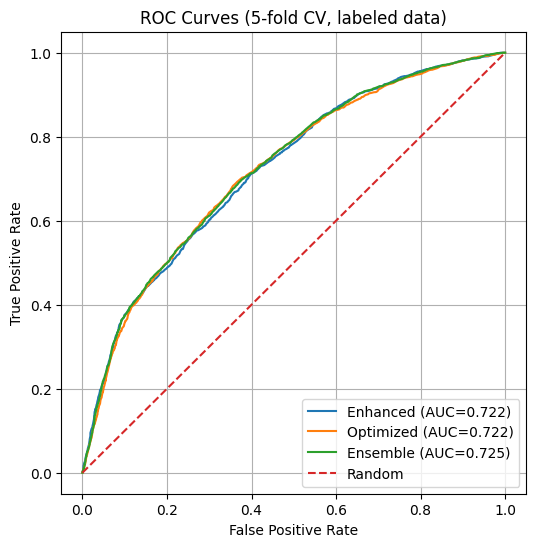

In [ ]:
    # ---------------------------------------------
    # PLOT 1: ROC curves (5-fold CV, labeled data)
    # ---------------------------------------------
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve

    y_cv = results['y_cv']
    enh_probs_cv = results['enhanced_probs_cv']
    opt_probs_cv = results['optimized_probs_cv']
    ens_probs_cv = results['ensemble_probs_cv']

    enh_res = results['enhanced_results_cv']
    opt_res = results['optimized_results_cv']
    ens_res = results['ensemble_results_cv']

    fpr_enh, tpr_enh, _ = roc_curve(y_cv, enh_probs_cv)
    fpr_opt, tpr_opt, _ = roc_curve(y_cv, opt_probs_cv)
    fpr_ens, tpr_ens, _ = roc_curve(y_cv, ens_probs_cv)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr_enh, tpr_enh, label=f'Enhanced (AUC={enh_res["auc"]:.3f})')
    plt.plot(fpr_opt, tpr_opt, label=f'Optimized (AUC={opt_res["auc"]:.3f})')
    plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC={ens_res["auc"]:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (5-fold CV, labeled data)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


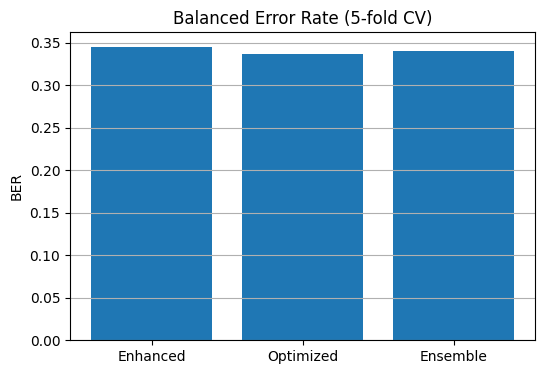

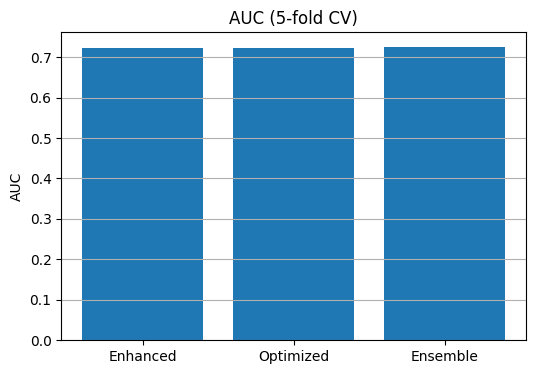

In [ ]:
    # ---------------------------------------------
    # PLOT 2: BER and AUC comparison (bar charts)
    # ---------------------------------------------
    models = ['Enhanced', 'Optimized', 'Ensemble']
    ber_values = [
        enh_res['ber'],
        opt_res['ber'],
        ens_res['ber'],
    ]
    auc_values = [
        enh_res['auc'],
        opt_res['auc'],
        ens_res['auc'],
    ]

    # BER bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(models, ber_values)
    plt.ylabel('BER')
    plt.title('Balanced Error Rate (5-fold CV)')
    plt.grid(axis='y')
    plt.show()

    # AUC bar chart
    plt.figure(figsize=(6, 4))
    plt.bar(models, auc_values)
    plt.ylabel('AUC')
    plt.title('AUC (5-fold CV)')
    plt.grid(axis='y')
    plt.show()


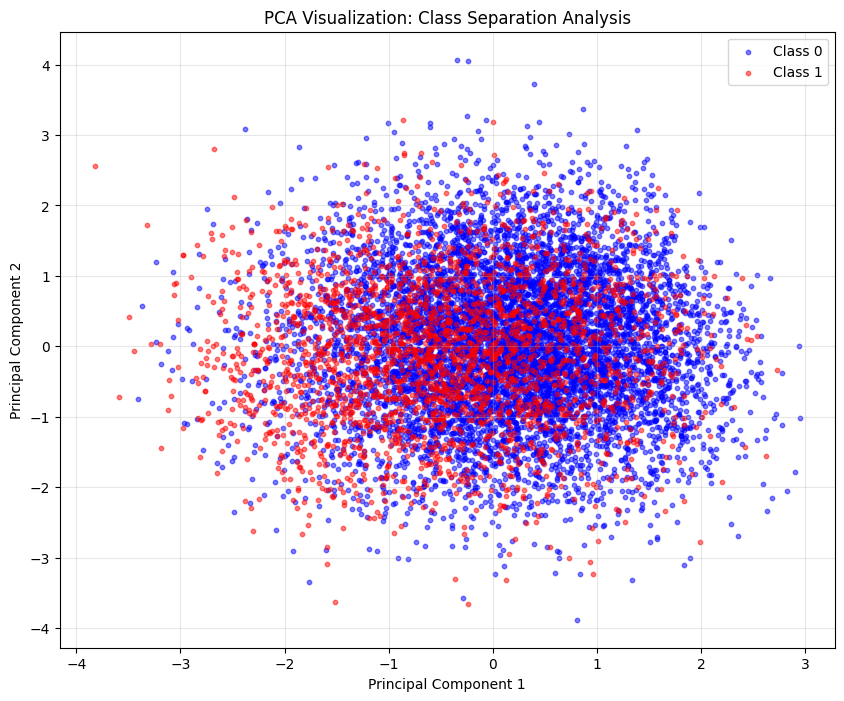

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Scale the data (PCA requires this)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Compress to 2 Dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 3. Plot
plt.figure(figsize=(10, 8))
# Plot Class 0
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1],
            color='blue', alpha=0.5, label='Class 0', s=10)
# Plot Class 1
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1],
            color='red', alpha=0.5, label='Class 1', s=10)

plt.title('PCA Visualization: Class Separation Analysis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("PCA_Class_Overlap.png")
plt.show()